In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Nernst = lambda C_out, C_in, z: R * T / (z * F) * np.log(C_out / C_in)
def GHK(V, C_out, C_in, z, P):
    RT = R * T
    e = np.exp(-z * F * V / RT)
    return P * (z * F) ** 2 / RT * V * ((C_in - C_out * e) / (1 - e))

In [3]:
F = 96485.3      # [A s mol^-1]
R = 8.3145       # [J K^-1 mol^-1]
T = 273.15 + 6.3 # [K]
C_in = {'K': 400e-3, 'Na': 50e-3, 'Cl': 40e-3, 'Ca': 1e-7}     # [mol]
C_out = {'K': 20e-3, 'Na': 440e-3, 'Cl': 560e-3, 'Ca': 10e-3}  # [mol]
z = {'K': 1, 'Na': 1, 'Cl': -1, 'Ca': 2} # [1]
P = {'K': 1, 'Na': 1, 'Cl': 1, 'Ca': 1}  # [cm s^-1]
E = {key: Nernst(C_out[key], C_in[key], z[key]) for key in z}

In [4]:
V = np.linspace(-150, 100, 200) * 1e-3
I = {key: GHK(V, C_out[key], C_in[key], z[key], P[key]) for key in z}

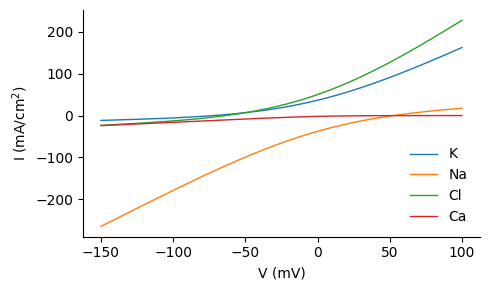

In [5]:
fig,ax = plt.subplots(1, 1, figsize=(5,3))
for key in I:
    ax.plot(V * 1e3, I[key] * 1e-3, lw=1, label=key)
ax.set_xlabel('V (mV)')
ax.set_ylabel(r'I (mA/cm$^2$)')
ax.legend(loc='lower right', frameon=False)
sns.despine()
fig.tight_layout()

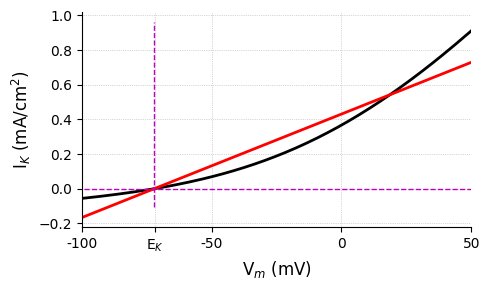

In [9]:
ion = 'K'
idx, = np.where((V > -0.1) & (V < 0.05))
Ix = lambda Vm,gx,Ex: gx * (Vm - Ex)
popt,_ = curve_fit(lambda Vm, gx: Ix(Vm, gx, E[ion]), V[idx], I[ion][idx])
fig,ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(V * 1e3, I[ion] * 1e-5, 'k', lw=2)
ax.plot([-100,50], Ix([-0.1,0.05], popt[0], E[ion]) * 1e-5, 'r', lw=2)
ylim = [I[ion].min()*1e-5-0.05, I[ion].max()*1e-5+0.05]
ax.plot(E[ion] * 1e3 + np.zeros(2), ylim, 'm--', lw=1)
ax.plot(ax.get_xlim(), np.zeros(2), 'm--', lw=1)
ax.grid(which='major', lw=0.5, ls=':')
ax.set_xlabel(r'V$_m$ (mV)', fontsize=12)
ax.set_ylabel(r'I$_{{{}}}$ (mA/cm$^2$)'.format(ion), fontsize=12)
ax.set_xlim([-100, 50])
xticks = list(range(-100, 51, 50))
xticklabels = [f'{xtick:.0f}' for xtick in xticks]
xticks.append(int(E[ion] * 1e3))
xticklabels.append(r'E$_{}$'.format(ion))
idx = np.argsort(xticks)
xticks = [xticks[i] for i in idx]
xticklabels = [xticklabels[i] for i in idx]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
sns.despine()
fig.tight_layout()

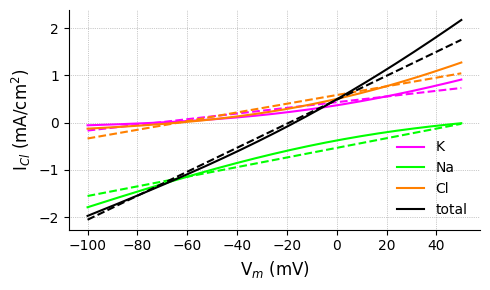

In [7]:
V = np.linspace(-100, 50, 150) * 1e-3
I = {key: GHK(V, C_out[key], C_in[key], z[key], P[key]) for key in z}
Ix = lambda Vm, gx, Ex: gx * (Vm - Ex)
cmap = {'Na': [0,1,0], 'K': [1,0,1], 'Cl': [1,0.5,0], 'Ca': [.5,1,1]}
popt = {}
Itot = 0
gL = 0
IL = 0
ions = 'K', 'Na', 'Cl'
fig,ax = plt.subplots(1, 1, figsize=(5,3))
for ion in ions:
    popt[ion],_ = curve_fit(lambda Vm, gx: Ix(Vm, gx, E[ion]), V, I[ion])
    gL += popt[ion][0]
    IL += popt[ion][0] * E[ion]
    Itot += I[ion]
    ax.plot(V * 1e3, I[ion] * 1e-5, color=cmap[ion], label=ion)
    ax.plot(V * 1e3, Ix(V, popt[ion][0], E[ion]) * 1e-5, '--', color=cmap[ion])
EL = IL / gL
ax.plot(V * 1e3, Itot * 1e-5, 'k', label='total')
ax.plot(V * 1e3, Ix(V, gL, EL) * 1e-5, 'k--')
ax.legend(loc='lower right', frameon=False)
sns.despine()
ax.grid(which='major', axis='both', lw=0.5, ls=':', color=[.6,.6,.6])
ax.set_xlabel(r'V$_m$ (mV)', fontsize=12)
ax.set_ylabel(r'I$_{{{}}}$ (mA/cm$^2$)'.format(ion), fontsize=12)
fig.tight_layout()